In [1]:
import os, re, sys, argparse, math, random
import numpy as np
from enum import Enum
from itertools import chain
from network_topology import *
from matplotlib_helper import *
from common_util import *
from math import sqrt
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from dataclasses import dataclass
from typing import List

Processing flow_size = 1500B, mode = single, K=1


1500B ('single', 1)
	average: 0.0188 +/- 0.00012
	median: 0.0206 +/- 0
	percent90: 0.0206 +/- 0
	percent99: 0.0216 +/- 0.0016
	max: 0.0248 +/- 6e-05
	min: 0.00908 +/- 0.0017


Processing flow_size = 1500B, mode = homogeneous, K=1


1500B ('homogeneous', 1)
	average: 0.0188 +/- 0.00012
	median: 0.0206 +/- 0
	percent90: 0.0206 +/- 0
	percent99: 0.0216 +/- 0.0016
	max: 0.0248 +/- 6e-05
	min: 0.00908 +/- 0.0017


Processing flow_size = 1500B, mode = heterogeneous, K=1


1500B ('heterogeneous', 1)
	average: 0.0162 +/- 0.00014
	median: 0.0165 +/- 0
	percent90: 0.019 +/- 0.002
	percent99: 0.0206 +/- 0
	max: 0.0209 +/- 5.7e-05
	min: 0.00825 +/- 0


Processing flow_size = 1500B, mode = large, K=1


1500B ('large', 1)
	average: 0.0183 +/- 0.00012
	median: 0.0202 +/- 0
	percent90: 0.0202 +/- 0
	percent99: 0.021 +/- 0.0016
	max: 0.0242 +/- 1.5e-05
	min: 0.00887 +/- 0.0016


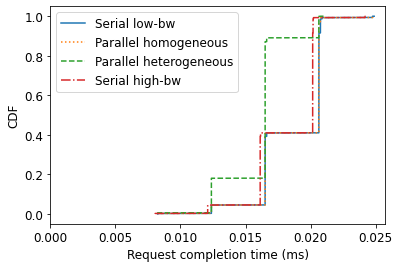

In [2]:
# Figure 10 and table 2

ROOT_DIR = '../data/2.app/1.small-rpc/64B.one-app'

Ks = [ 1 ]
flow_sizes = ['1500B'] # Should be ordered
modes = [ 'single', 'homogeneous', 'heterogeneous', 'large' ] # 1*10G, 4*10G, 4*10G, 1*40G
EXP_COUNT = 5

curr_mode = None
curr_color = None
for flow_size in flow_sizes:
    plt.figure()
    index = -1
    for mode in modes:
        index += 1
        data = {}
        for K in Ks:
            if mode != 'parallel' and K > 1:
                continue
            if mode == 'parallel' and K != 4:
                continue
            dir_size = os.path.join(os.path.expanduser(ROOT_DIR), 'rawdata')
            name = (mode, K)
            data[name] = {}
            eprint('Processing flow_size = %s, mode = %s, K=%d' % (flow_size, mode, K))
            for exp in range(1, EXP_COUNT + 1):
                dirname = 'exp%d.%s' % (exp, mode)
                fct_filename = os.path.join(dir_size, dirname, 'fct.ssv')
                if not os.path.exists(fct_filename):
                    eprint('"%s" not found' % fct_filename)
                    continue
                d = parse_fct(fct_filename)
                fct_array = np.array(sorted(get_fct_array(d))) * 1e3 # ms
                data[name][exp] = fct_array
            combined_fct = list(chain.from_iterable(data[name].values()))
            stats = get_stats(data[name])
            if name != curr_mode:
                curr_mode = name
                curr_color = get_next_color()
            label = '%s K=%d' % (name[0], name[1])
            plot_cdf_array(combined_fct, get_exp_name(mode), index = index, color=curr_color)
            print('%s %s' % (flow_size, name))
            for k, v in stats.items():
                print ('\t%s: %.3g +/- %.2g' % (k, np.average(v), np.std(v)))
        plt.legend()
        plt.xlabel('Request completion time (ms)')
        plt.ylabel('CDF')
        plt.xlim(0, None)
        if save_figures:
            plt.savefig('%s.png' % flow_size)


In [3]:
# Varying loads
ROOT_DIR = '../data/2.app/1.small-rpc/rpc.100kB.load'

EXPERIMENTS = ['single', 'homogeneous', 'heterogeneous', 'large']
# EXPERIMENTS = ['high-radix']

FLOW_COUNT = 686 * 1
REQUEST_FLOW_SIZE = 64
TM_COUNT=10

values_x = [v + 1 for v in range(TM_COUNT)]
d_by_metrics_exp = {}
m_fct_values = {}
for experiment in EXPERIMENTS:
    # plt.figure()
    experiment_name = get_experiment_name(experiment)
    # print('exp: ' + experiment_name)
    m_fct_values[experiment] = {}
    for tm_count in range(1, TM_COUNT + 1):
        exp_root_dir = os.path.join(os.path.expanduser(ROOT_DIR), '%s.%dtm' % (experiment, tm_count))
        flow_map = parse_log(os.path.join(exp_root_dir, 'run.log'))
        id_map = parse_ids_from_log(os.path.join(exp_root_dir, 'logout.dat'))
        assert len(flow_map) == 2 * FLOW_COUNT * tm_count, 'Found %d items in flow map' % len(flow_map)
        (request_id_map, response_id_map) = get_request_to_response_id_map(id_map)
        application_fct_map = {}
        request_count = 0
        response_count = 0
        for flow_id, (flow_size, flow_fct) in flow_map.items():
            if flow_size == REQUEST_FLOW_SIZE:
                request_count += 1
                flow_name = request_id_map[flow_id]
                application_fct_map[flow_name] = flow_fct
            else:
                response_count += 1
                flow_name = response_id_map[flow_id]
                application_fct_map[flow_name] += flow_fct
        fct_values = sorted(list(application_fct_map.values()))
        fct_values_in_ms = np.array(fct_values) * 1e3
        # plot_cdf_array(fct_values_in_ms, label="%d flows" % tm_count)
        m_fct_values[experiment][tm_count] = fct_values_in_ms
    # plt.legend()
    # plt.xlim(0, 0.2)
    # plt.xlabel('Completion time (ms)')
    # plt.ylabel('CDF')
    # plt.title('RPC 64B/100kB | varying loads | %s' % experiment_name)
    # plt.savefig('rpc.100kB.varying-loads.%s.png' % experiment)
    d = get_stats(m_fct_values[experiment])
    for k, v in d.items():
        # print('\t%s: %.3g' % (k, v[0]))
        if k not in d_by_metrics_exp:
            d_by_metrics_exp[k] = {}
        if experiment not in d_by_metrics_exp[k]:
            d_by_metrics_exp[k][experiment] = v
        else:
            raise ValueError('duplicate')

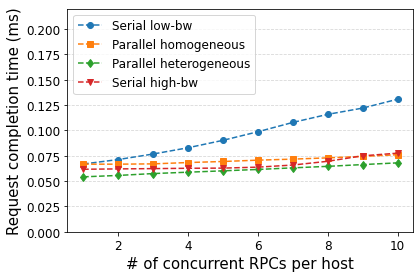

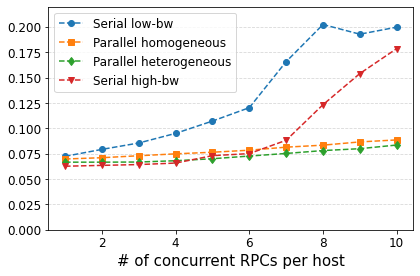

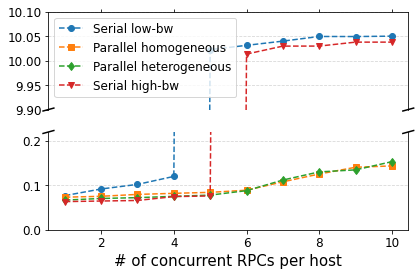

In [4]:
# Figure 11

MARKER_INDEX = {
    'single': 1,
    'large': 4,
    'homogeneous': 2,
    'heterogeneous': 3,
}
for metric in ['median', 'percent90', 'percent99']:
    if metric == 'percent99':
        _, (ax2, ax) = plt.subplots(2, 1, sharex=True)
    else:
        fig = plt.figure()
        ax2 = plt.gca()
        ax = None
#     plt.title(metric)
    for exp in d_by_metrics_exp[metric]:
        values_y = d_by_metrics_exp[metric][exp]
        for ax_ in [ax, ax2]:
            if ax_ is not None:
                ax_.plot(values_x, values_y, label=get_exp_name(exp), marker=get_marker(MARKER_INDEX[exp]), linestyle='--')
#         plt.yscale('log')
    if metric == 'percent99':
        ax2.set_ylim(9.9, 10.1)  # outliers only
        ax.set_ylim(0, .22)  # most of the data
        ax.yaxis.grid(True, alpha=0.5, linestyle='--')

        # hide the spines between ax and ax2
        ax2.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax2.xaxis.tick_top()
        ax2.tick_params(labeltop=False)  # don't put tick labels at the top
        ax2.yaxis.set_label_coords(0.5, 0.5, transform=fig.transFigure)
        ax.xaxis.tick_bottom()
        
        d = .015  # how big to make the diagonal lines in axes coordinates
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
        ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
        ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

        kwargs.update(transform=ax.transAxes)  # switch to the bottom axes
        ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
        ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    else:
        plt.ylim(0, .22)
    ax2.yaxis.grid(True, alpha=0.5, linestyle='--')
    ax2.legend(loc='upper left')
    plt.xlabel('# of concurrent RPCs per host', fontsize=15)
    if metric == 'median':
        plt.ylabel('Request completion time (ms)', fontsize=15)
    plt.tight_layout()
    plt.savefig('rpc.concurrent.%s.png' % metric)